In [2]:
# !export CUDA_VISIBLE_DEVICES=0,1

In [1]:
from fastai.vision.all import *

In [3]:
Path.BASE_PATH = path = Path.home()/'.fastai/data/paddy'; path.ls()

(#4) [Path('sample_submission.csv'),Path('train.csv'),Path('train_images'),Path('test_images')]

In [4]:
df = pd.read_csv(path/'train.csv'); df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [5]:
trn_path = path/'train_images'; trn_path

Path('train_images')

In [6]:
files = get_image_files(path/'train_images')

In [7]:
img = PILImage.create(files[0])

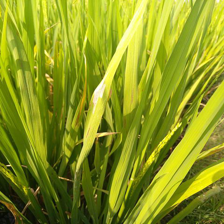

In [8]:
img.resize((224,224))

In [9]:
img.size

(480, 640)

In [10]:
pd.DataFrame([str(PILImage.create(o).size) for o in files],columns =['dims']).value_counts()

dims      
(480, 640)    10403
(640, 480)        4
dtype: int64

In [11]:
df.variety.value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [12]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(224))

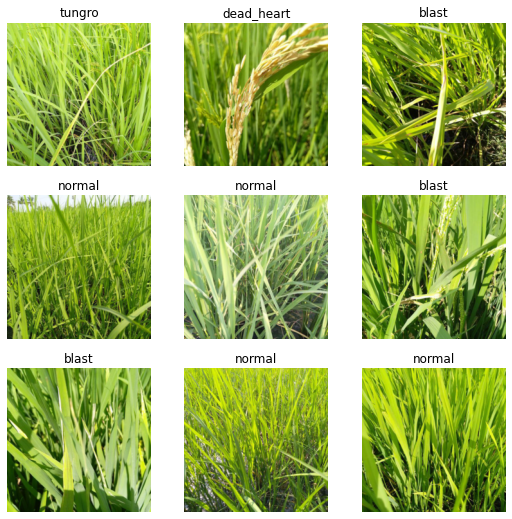

In [13]:
dls.show_batch()

In [14]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [15]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.934172,1.016978,0.330610,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.858503,0.477620,0.146084,00:15
1,0.431190,0.300268,0.090822,00:15
2,0.180805,0.219197,0.059587,00:15
3,0.079919,0.180041,0.049015,00:15
4,0.042340,0.171600,0.041807,00:15


In [19]:
interp = ClassificationInterpretation.from_learner(learn)

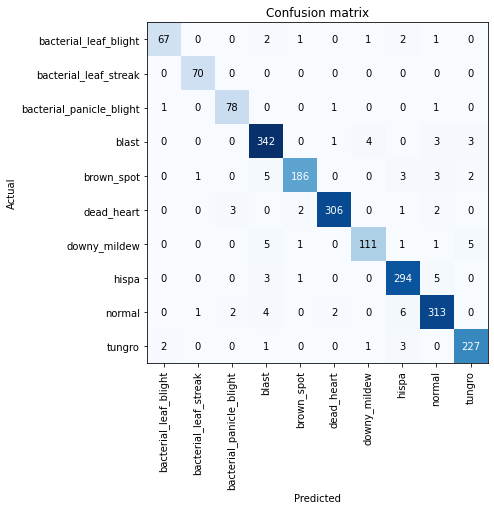

In [21]:
interp.plot_confusion_matrix(figsize=(7,7))

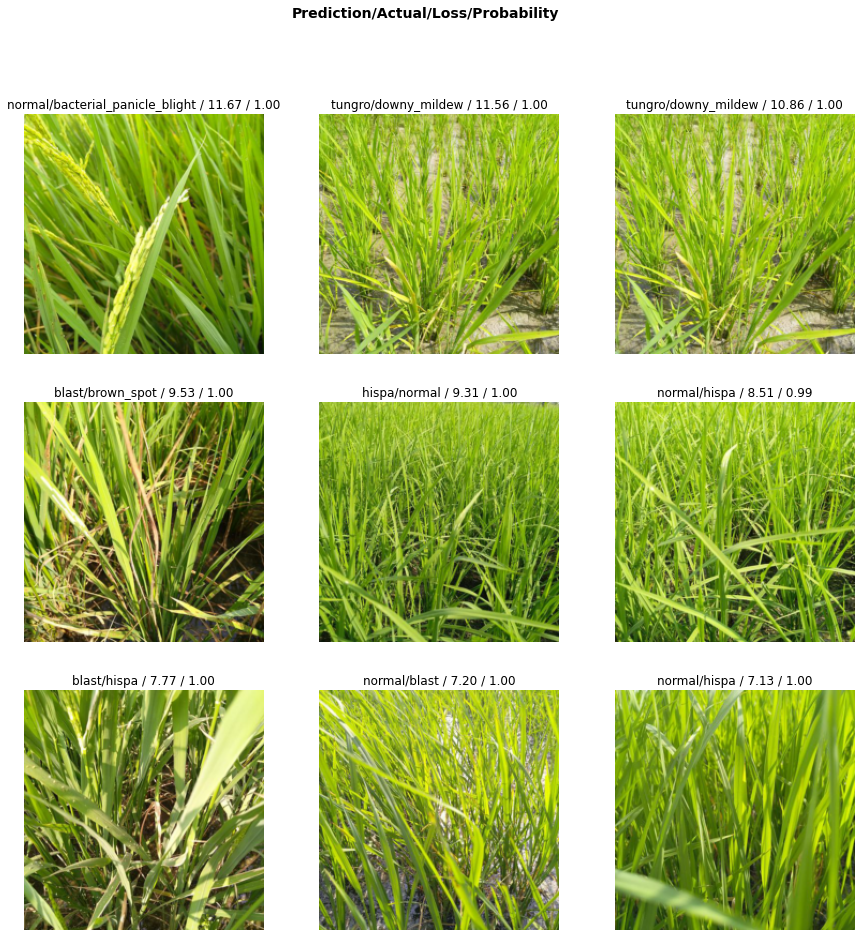

In [23]:
interp.plot_top_losses(9, figsize=(15,15))

In [25]:
learn.export('paddle.pkl')